In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt

In [21]:
from art.attacks.inference import model_inversion
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist
from PIL import Image

In [22]:
# Step 0: Define the neural network model, return logits instead of activation in forward method

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.fc_1 = nn.Linear(in_features=5 * 5 * 64, out_features=128)
        self.fc_2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 64)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)

        x = F.softmax(x, dim=1)
        return x

In [23]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
print(x_train.shape)
print(min_pixel_value)
print(max_pixel_value)

(60000, 28, 28, 1)
0.0
1.0


In [24]:
# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)
print(x_train.shape,x_test.shape)

(60000, 1, 28, 28) (10000, 1, 28, 28)


In [25]:
# # Step 2: Create the model

# model = Net()
# model = torchvision.models.resnet18()
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
# device = torch.device('mps')
# model.to(device)
model = Net()
model = torch.load("/Users/songjunzhe/Desktop/python/ml_attack/myNet_mnist_98_7300.pt")
model.eval()
model.to(torch.device('mps'))

Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=1600, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
)

In [26]:
# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-3, momentum=0.9)

In [27]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),  #vgg11 train on mnist, figure resize to (32*32)
    nb_classes=10,
)

In [28]:
# Step 4: Train the ART classifier

# classifier.fit(x_train, y_train, batch_size=128, nb_epochs=5)

In [29]:
# Step 5: Create the attack object

my_attack = model_inversion.MIFace(classifier, max_iter=10000, threshold=1.)

In [30]:
# Step 6: Create an array of the classes to be attacked

y_all = np.arange(10)
y_all
# y_all = np.array([9])
# y_all


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
# We will experiment with a number of different initializations:

x_init_average = np.zeros((10, 1, 28, 28),dtype=np.float32) + np.mean(x_train, axis=0)
# x_init_average = np.zeros((1, 1, 28, 28),dtype=np.float32) + np.mean(x_train, axis=0)
# x_init_average = 1*np.random.random((1, 32, 32)).astype(np.float32)
# x_init_average = 1*np.random.random((1, 28, 28)).astype(np.float32) + np.mean(x_train, axis=0)

In [32]:
# plt.figure(figsize=(0.28,0.28),dpi=100,frameon=False)
# plt.axis('off')
# img = plt.imshow(x_init_average[0].squeeze(), cmap=plt.cm.gray_r)
# # plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
# # plt.margins(0,0)
# plt.savefig("/Users/songjunzhe/Desktop/python/ml_attack/mi-attack-result/miface_init.png")
# plt.close()

In [33]:
# class_gradient = classifier.class_gradient(x_init_average, y_all)
# # class_gradient = np.reshape(class_gradient, (10, 28*28))
# class_gradient = np.reshape(class_gradient, (1, 28*28))
# class_gradient_max = np.max(class_gradient, axis=1)

# print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

针对数字<5>, max_iter=10000, 用时11.4s

In [34]:
inferred_images = my_attack.infer(x=x_init_average,y=y_all)

Model inversion:   0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
inferred_images.shape

(10, 1, 28, 28)

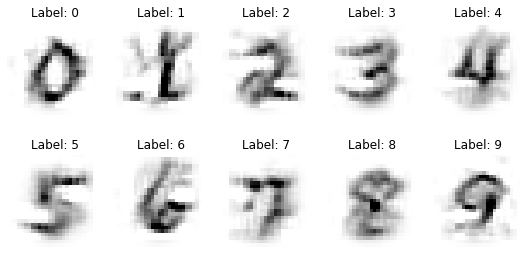

In [36]:
# plot the inverted class representations
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(10):
    ax = axes[i//num_col, i%num_col]
    ax.set_axis_off()
    ax.imshow(inferred_images[i,:,:,:].reshape(28,28), cmap=plt.cm.gray_r)
    ax.set_title('Label: {}'.format(y_all[i]))
plt.savefig("/Users/songjunzhe/Desktop/python/ml_attack/mi-attack-result/miface-0-9-iter=10000")
plt.tight_layout()
plt.show()

In [37]:
# inferred_images = my_attack.infer(x=x_init_average,y=y_all)
# plt.figure(figsize=(0.28,0.28),dpi=100,frameon=False)
# plt.axis('off')
# img = plt.imshow(inferred_images.squeeze(),cmap=plt.cm.gray_r)
# plt.show()
# plt.close()

In [38]:
# for i in range(1,300):
#     my_attack = model_inversion.MIFace(classifier, max_iter=i, threshold=1.)
#     inferred_images = my_attack.infer(x=x_init_average, y=y_all)
#     #print(inferred_images.shape)
#     plt.figure(figsize=(0.28,0.28),dpi=100,frameon=False)
#     plt.axis('off')
#     img = plt.imshow(inferred_images.squeeze(), cmap=plt.cm.gray_r)
#     # plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0,wspace=0)
#     # plt.margins(0,0)
#     plt.savefig("/Users/songjunzhe/Desktop/python/ml_attack/mi-attack-result/miface-9-iter300/iter={}.png".format(i))
#     plt.close()